In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Floa

In [21]:
def comp_tiles(xr_dset):
    d_tile = np.tile(xr_dset.diameter, [np.shape(xr_dset.psd.values)[0], 1])
    dd_tile = np.tile(xr_dset.d_d, [np.shape(xr_dset.psd.values)[0], 1])
    return d_tile, dd_tile

def comp_lwc_raw(xr_dset):
    d, d_d = comp_tiles(xr_dset)     
    return (np.pi / (6.  * 1000.)) * (xr_dset.psd * 1e6) * (d * 1e-3) ** 3 * (d_d * 1e-3)

def add_colorbar_outside(im,ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.05 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    

In [18]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7999'})

cluster.scale(jobs=2)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://172.22.179.3:7223 Dashboard: /proxy/7999/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# rdm_idx = pd.date_range(start='2019-09-06 23:58:30', periods=60, tz='UTC', freq='S')  # for P3B
# rdm_idx = pd.date_range(start='2019-09-07 2:31:45', periods=150, tz='UTC', freq='S')  # for Lear
start = '2019-09-07 02:31:45'
end = '2019-09-07 02:33:30'
aircraft = 'Lear'
aircraft2 = 'Learjet'

In [7]:
store1 = f"{path_data}/zarr/combined_psd_{aircraft}_350_825.zarr"
store2 = f"{path_data}/zarr/combined_psd_{aircraft}_800_1200.zarr"
store3 = f"{path_data}/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/zarr/HVPS_{aircraft2}.zarr"
store5 = f"{path_data}/zarr/Page0_Learjet.zarr"
store6 = f"{path_data}/zarr/FFSSP_{aircraft2}.zarr"

In [33]:
xr_comb_350 = xr.open_zarr(store1)
xr_400 = xr_comb_350
xr_comb_800 = xr.open_zarr(store2)
xr_800 = xr_comb_800
xr_2ds = xr.open_zarr(store3)
xr_hvps = xr.open_zarr(store4)
xr_fssp = xr.open_zarr(store6)
xr_add = xr.open_zarr(store5)

(0.001, 10)

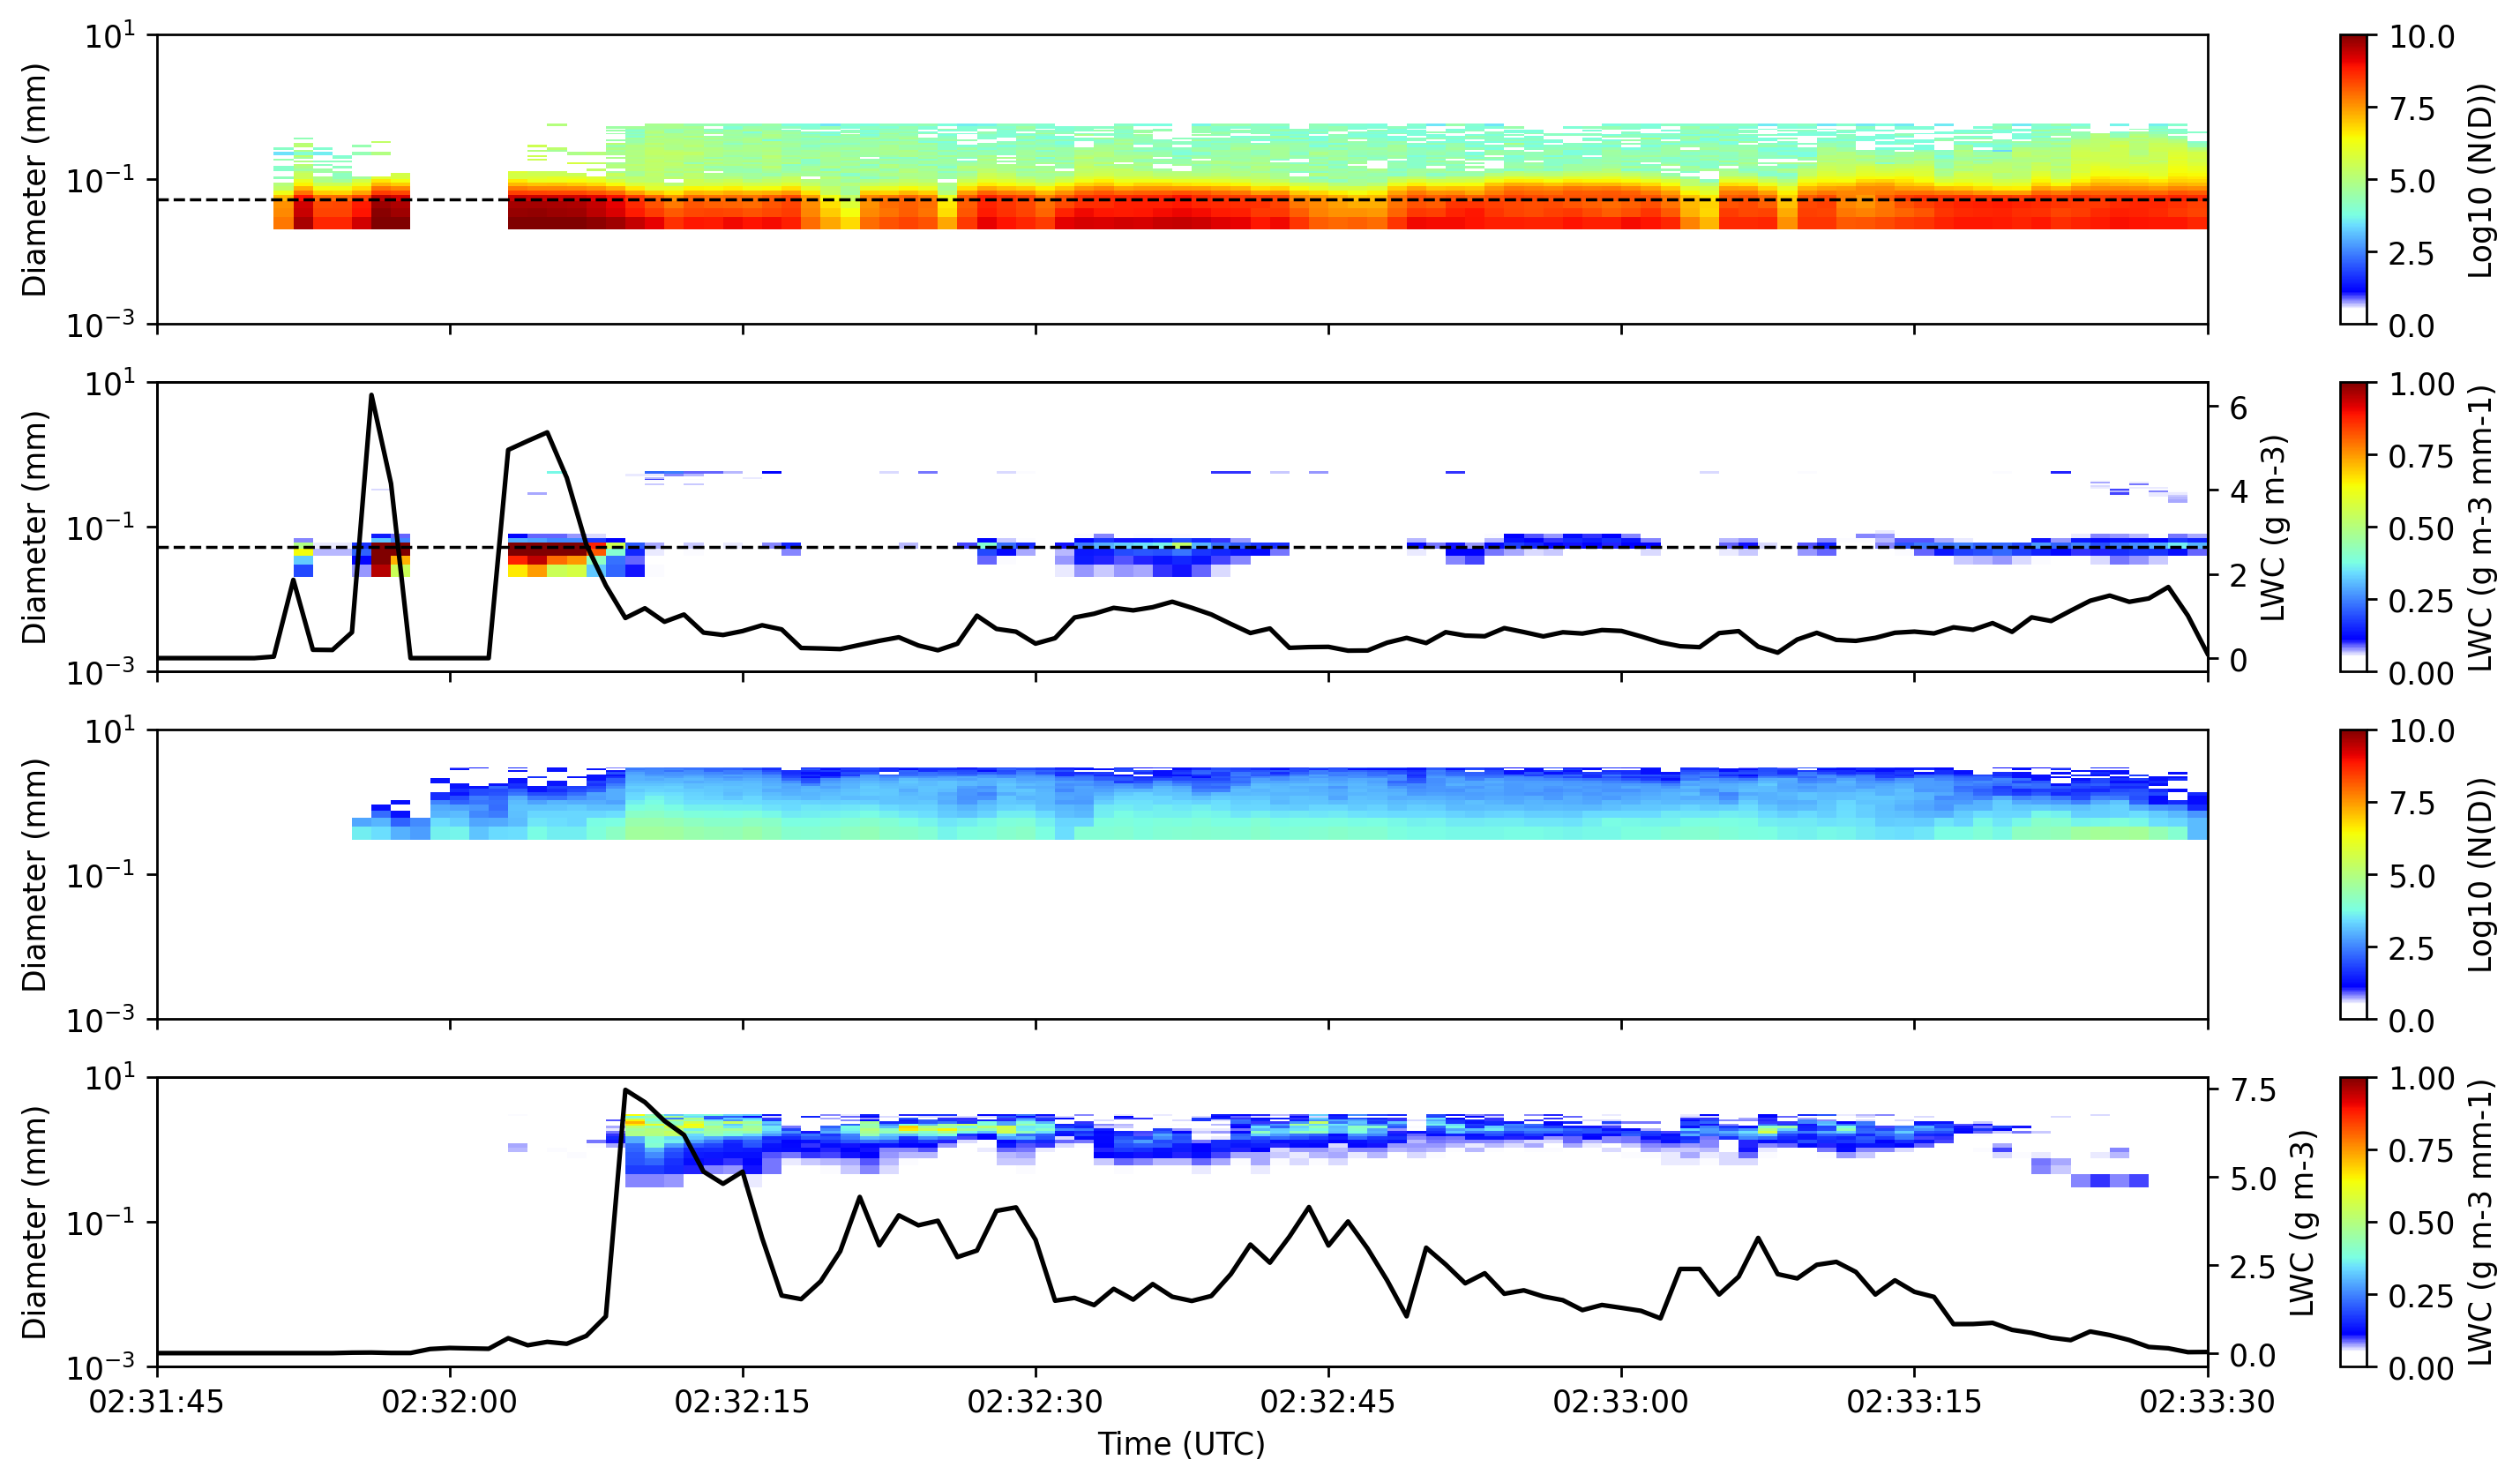

In [30]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(12, 8), sharex=True, dpi=250)

cbar = ax.pcolormesh(xr_2ds.time.sel(time=slice(start, end)), 
                      xr_2ds.diameter.sel(diameter=slice(20, 600)).values / 1e3, 
                      np.log10(xr_2ds.psd.sel(time=slice(start, end)).sel(diameter=slice(20, 600)).T.values * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)

lwc_2ds = comp_lwc_raw(xr_2ds.sel(time=slice(start, end)).sel(diameter=slice(20, 600)))

ax.hlines(xr_fssp.diameter.min() * 1e-3,  xr_fssp.time.sel(time=slice(start, end)).min(), 
           xr_fssp.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax.hlines(xr_fssp.diameter.max() * 1e-3, 
           xr_fssp.time.sel(time=slice(start, end)).min(), 
           xr_fssp.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', linestyles='--')


cbar1 = ax1.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)), 
                       lwc_2ds.diameter.values / 1e3, 
                       lwc_2ds.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap)

ax11= ax1.twinx()
ax11.plot(lwc_2ds.time, lwc_2ds.sum('diameter'), c='k')


ax1.hlines(xr_fssp.diameter.min() * 1e-3,  xr_fssp.time.sel(time=slice(start, end)).min(), 
           xr_fssp.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_fssp.diameter.max() * 1e-3, 
           xr_fssp.time.sel(time=slice(start, end)).min(), 
           xr_fssp.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', linestyles='--')



cbar2 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)), 
                      xr_hvps.diameter.sel(diameter=slice(300, 3000)).values / 1e3, 
                      np.log10(xr_hvps.psd.sel(time=slice(start, end)).sel(diameter=slice(300, 3000)).T.values * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)


lwc_hvps = comp_lwc_raw(xr_hvps.sel(time=slice(start, end)).sel(diameter=slice(300, 3000)))


cbar3 = ax3.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)), 
                       lwc_hvps.diameter.values / 1e3, 
                       lwc_hvps.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap)

ax33= ax3.twinx()
ax33.plot(lwc_hvps.time, lwc_hvps.sum('diameter'), c='k')

# cbar4 = ax4.pcolormesh(xr_fssp.time.sel(time=slice(start, end)), 
#                       xr_fssp.diameter.values / 1e3, 
#                       np.log10(xr_fssp.psd.sel(time=slice(start, end)).T.values * 1e6), 
#                       vmin=0, vmax=10, cmap=my_cmap)


# lwc_ffsp = comp_lwc_raw(xr_fssp.sel(time=slice(start, end)))

# cbar5 = ax5.pcolormesh(lwc_ffsp.time.sel(time=slice(start, end)), 
#                        lwc_ffsp.diameter.values / 1e3, 
#                        lwc_ffsp.T.values, 
#                        vmin=0, vmax=1, cmap=my_cmap)

# ax55= ax5.twinx()
# ax55.plot(lwc_ffsp.time, lwc_ffsp.sum('diameter'), c='k')

ax.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
add_colorbar_outside(cbar, ax, 'Log10 (N(D))')
add_colorbar_outside(cbar1, ax1, 'LWC (g m-3 mm-1)')
add_colorbar_outside(cbar2, ax2, 'Log10 (N(D))')
add_colorbar_outside(cbar3, ax3, 'LWC (g m-3 mm-1)')
ax.set_ylabel('Diameter (mm)')
ax1.set_ylabel('Diameter (mm)')
ax2.set_ylabel('Diameter (mm)')
ax3.set_ylabel('Diameter (mm)')
ax3.set_xlabel('Time (UTC)')
ax33.set_ylabel('LWC (g m-3)')
ax11.set_ylabel('LWC (g m-3)')


ax.set_ylim(0.001, 10)
ax1.set_ylim(0.001, 10)
ax2.set_ylim(0.001, 10)
ax3.set_ylim(0.001, 10)
ax4.set_ylim(0.001, 10)

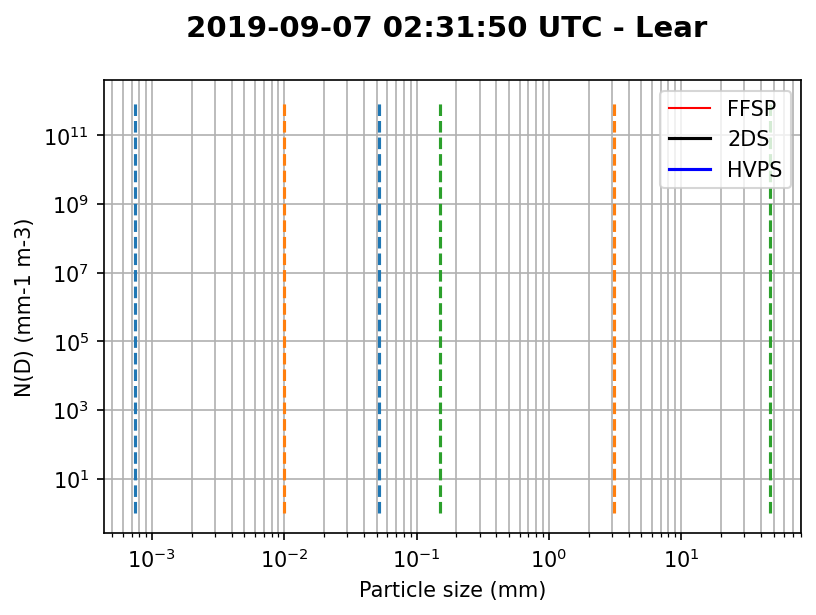

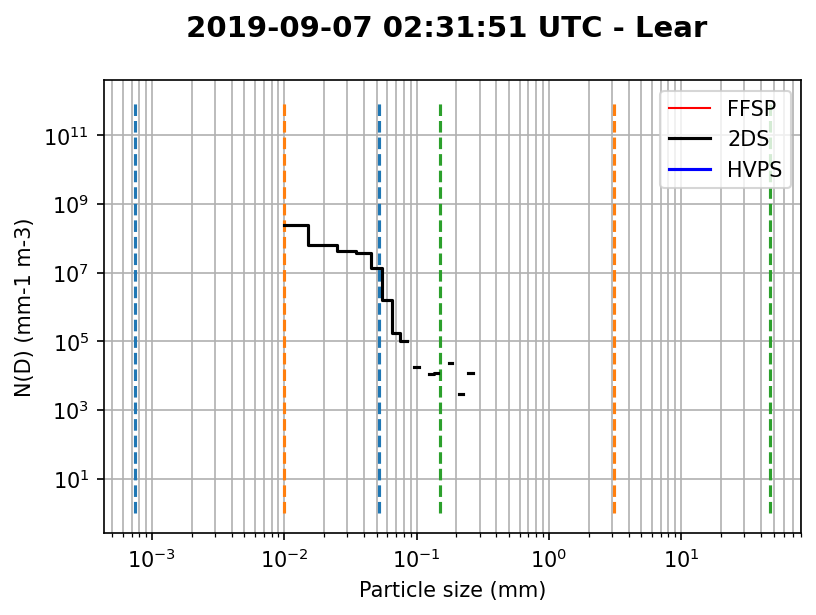

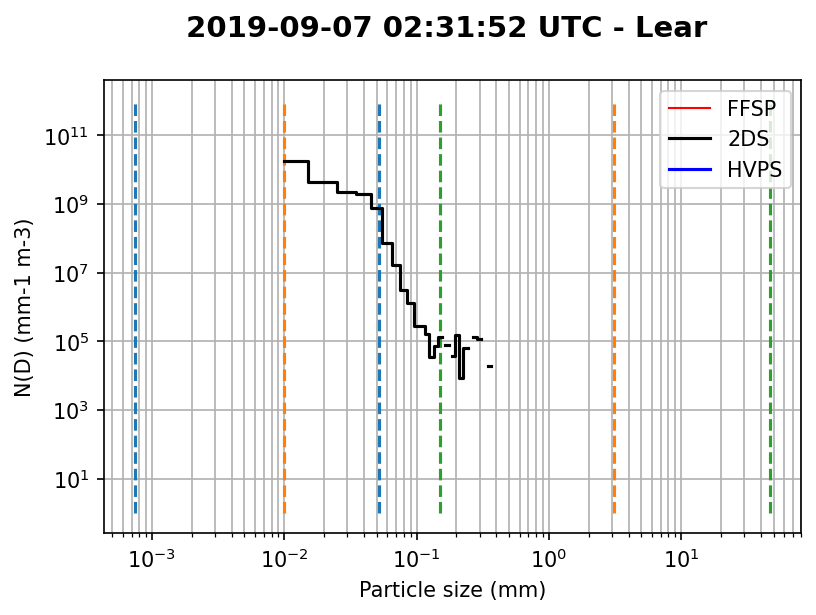

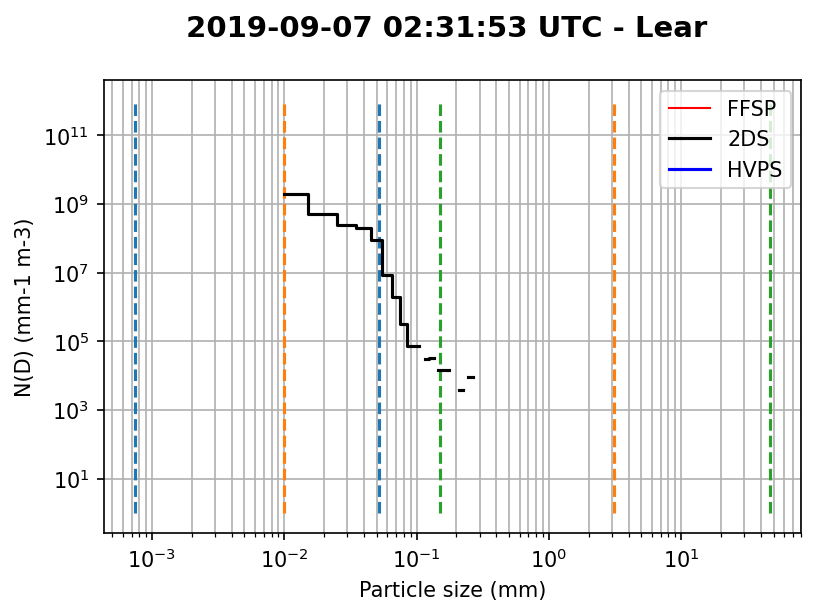

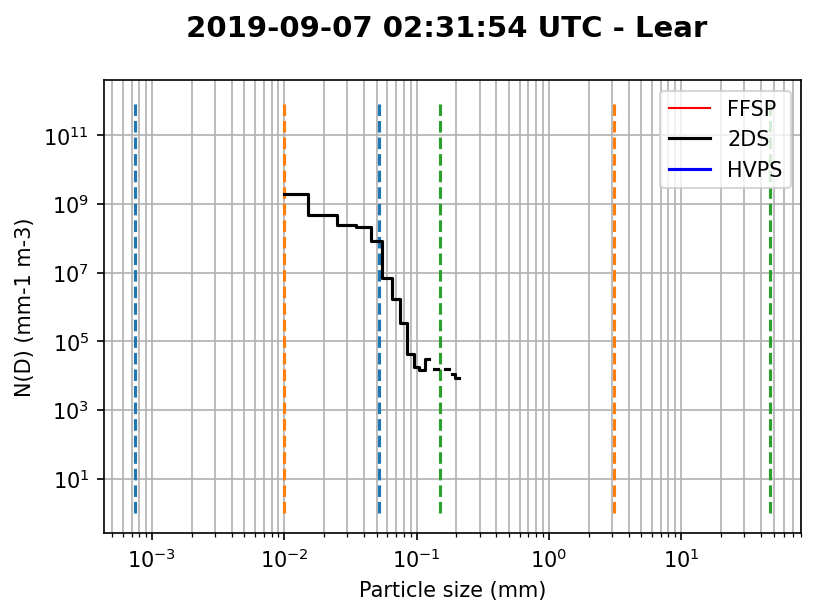

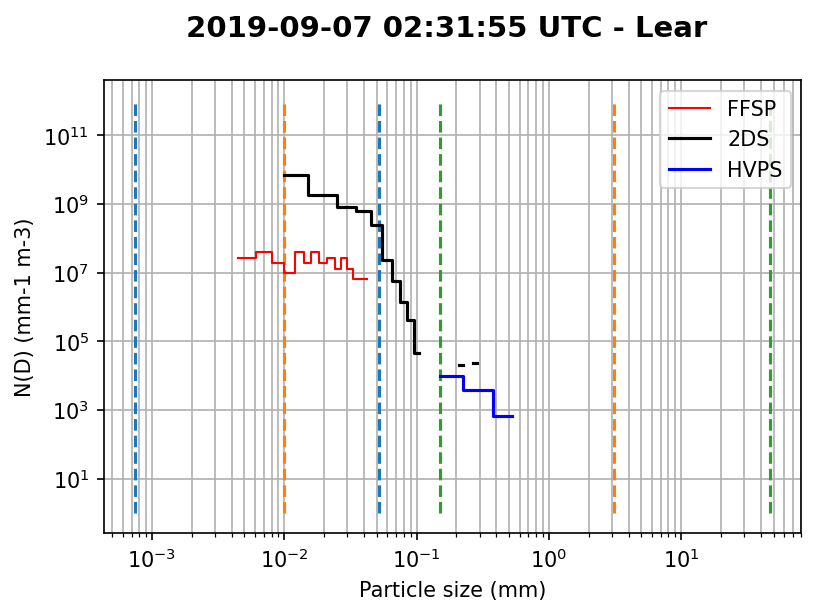

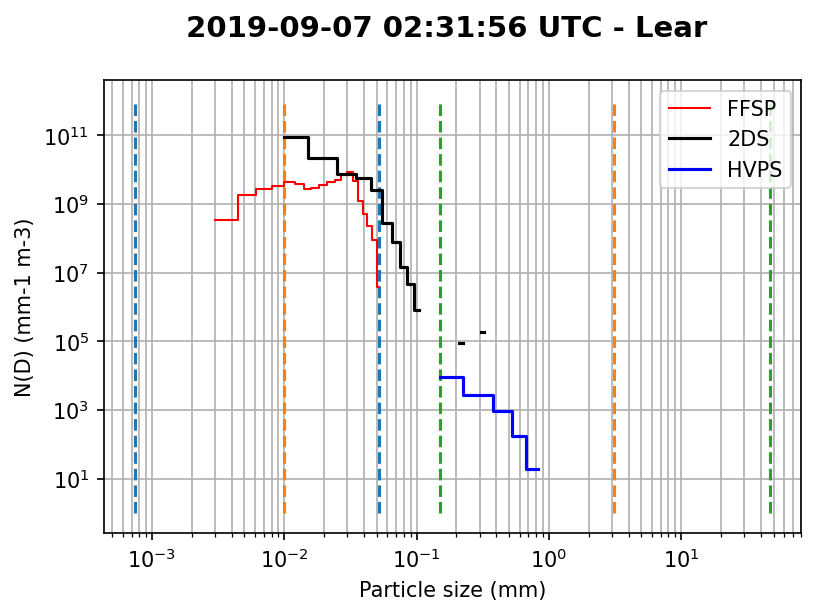

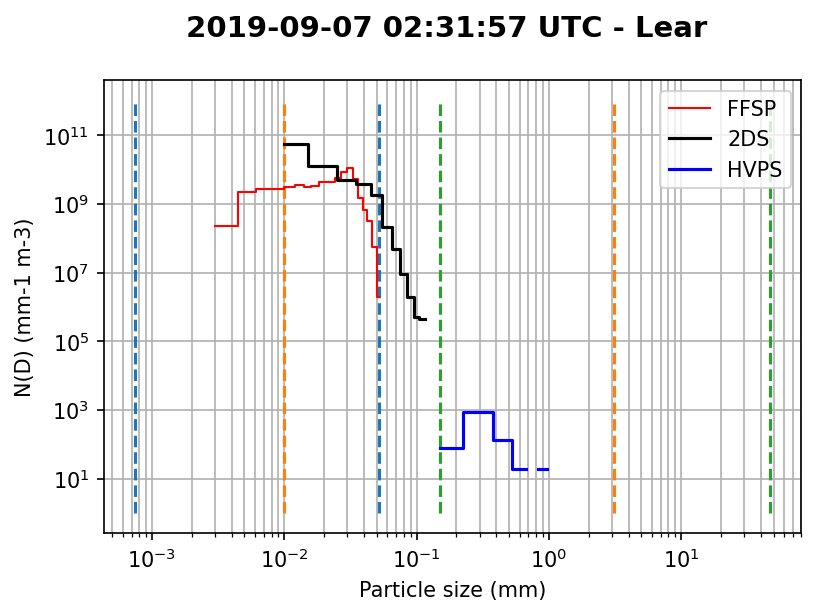

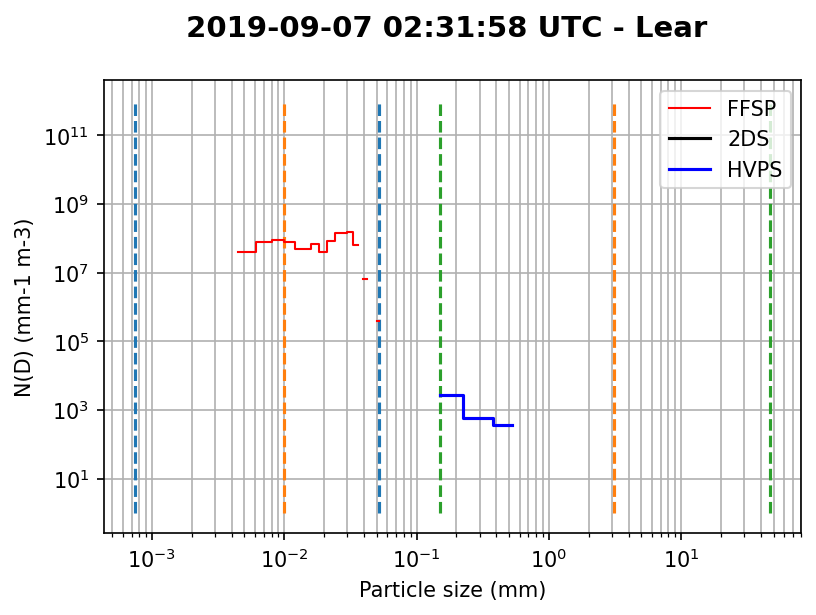

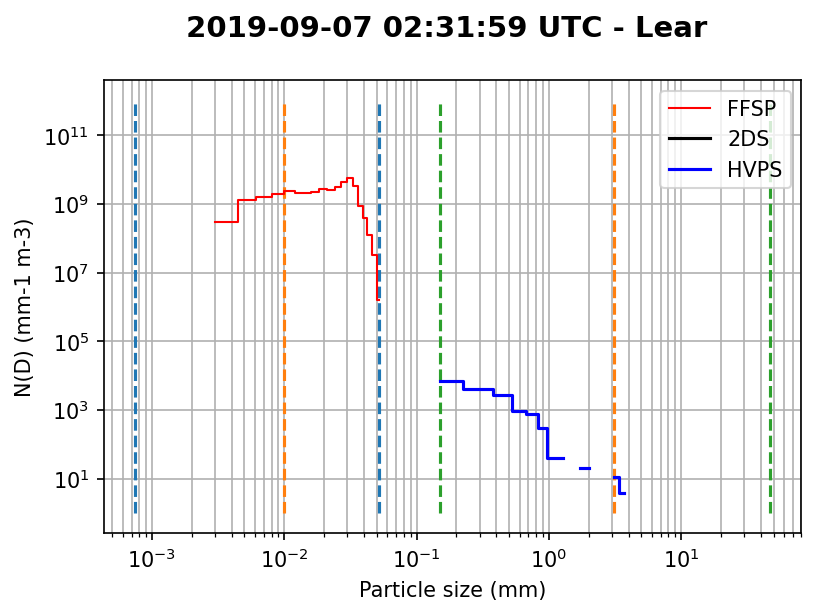

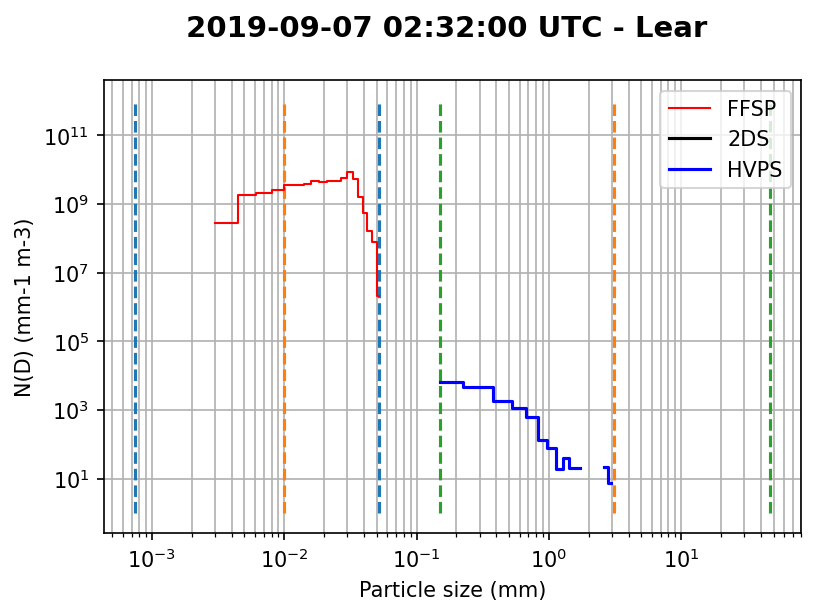

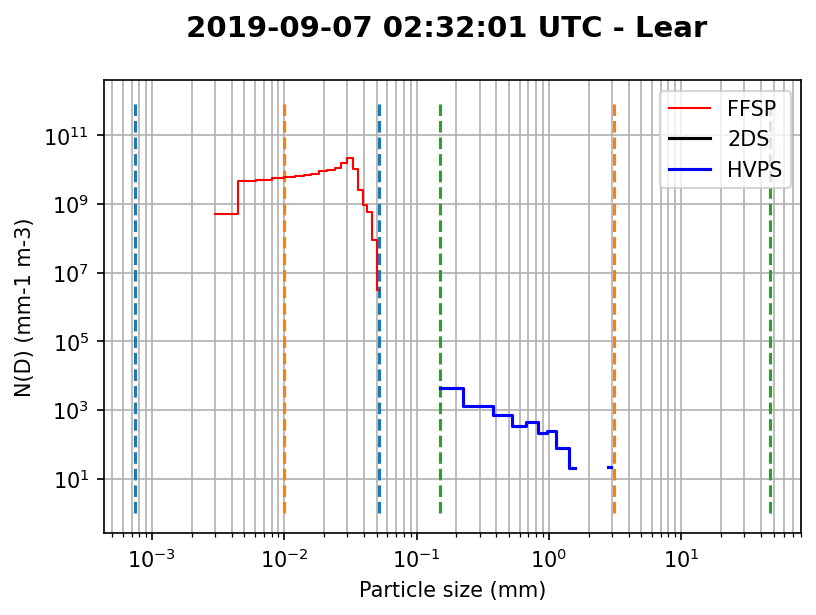

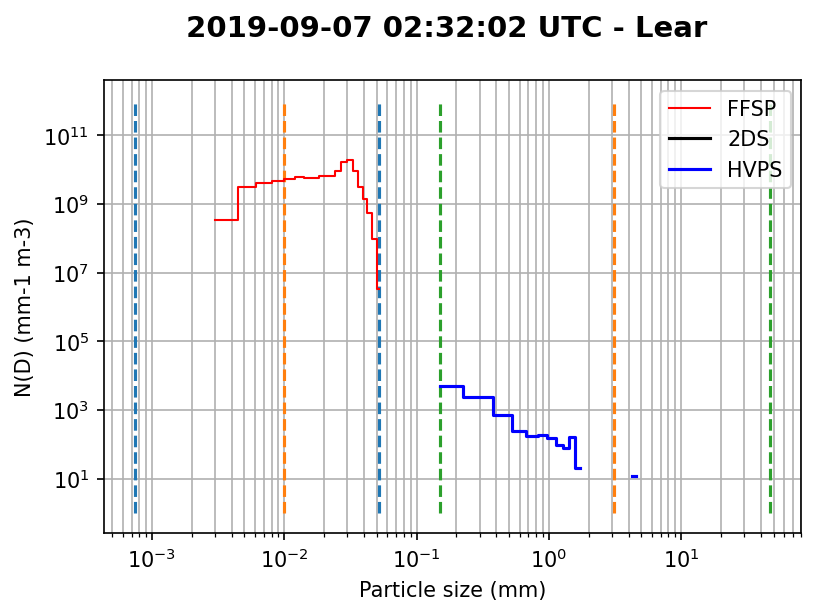

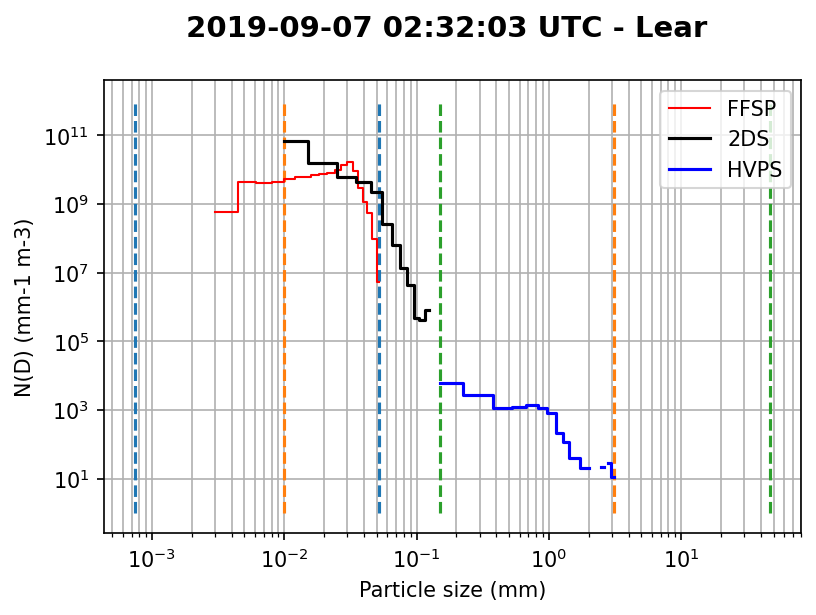

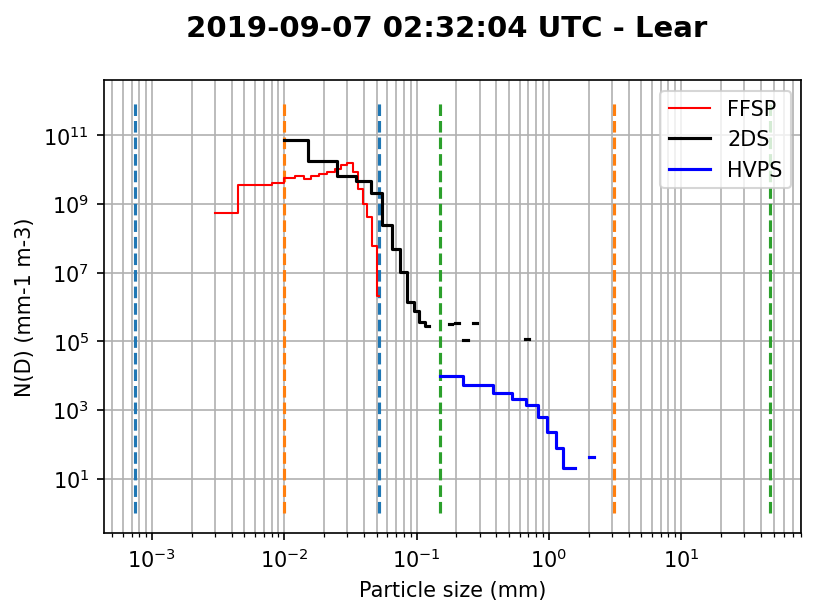

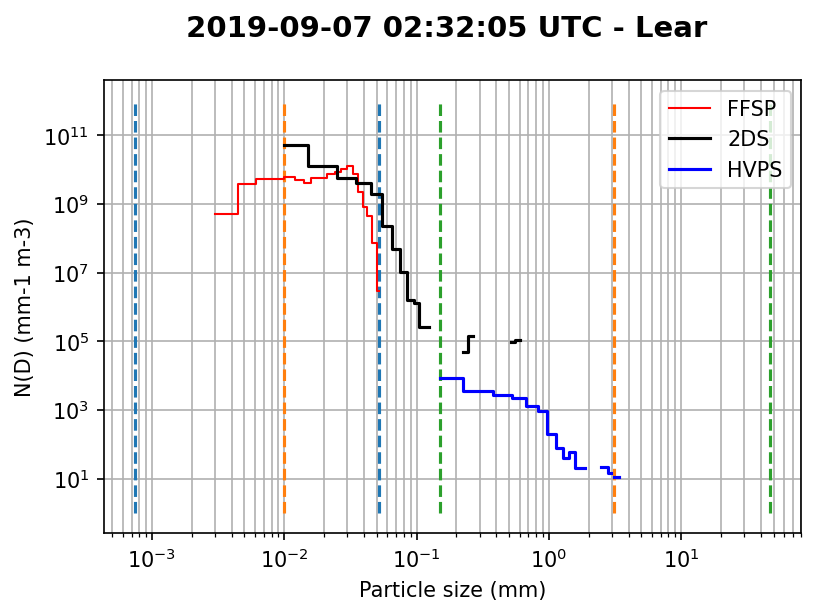

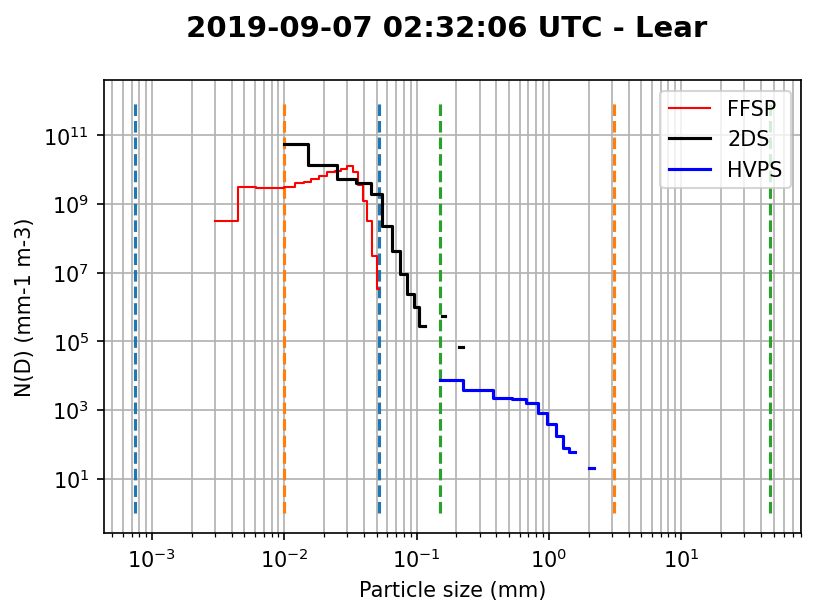

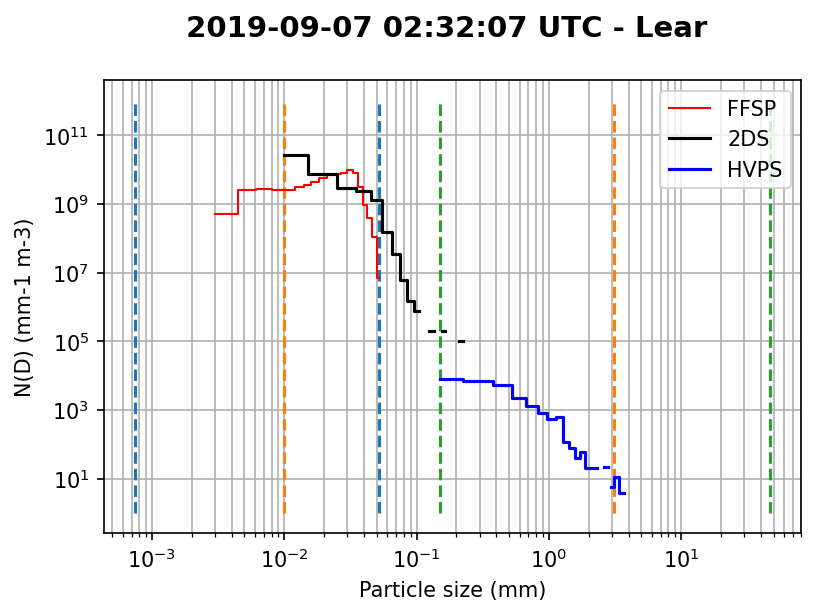

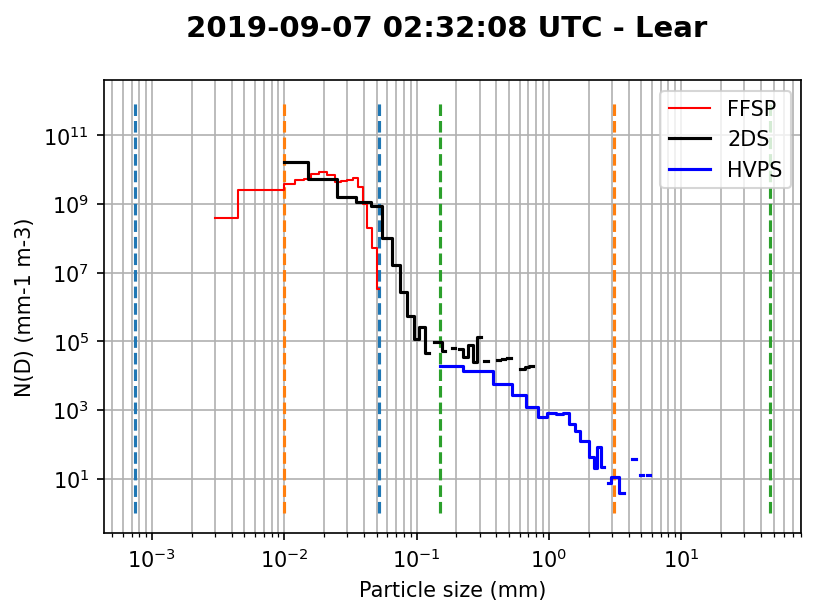

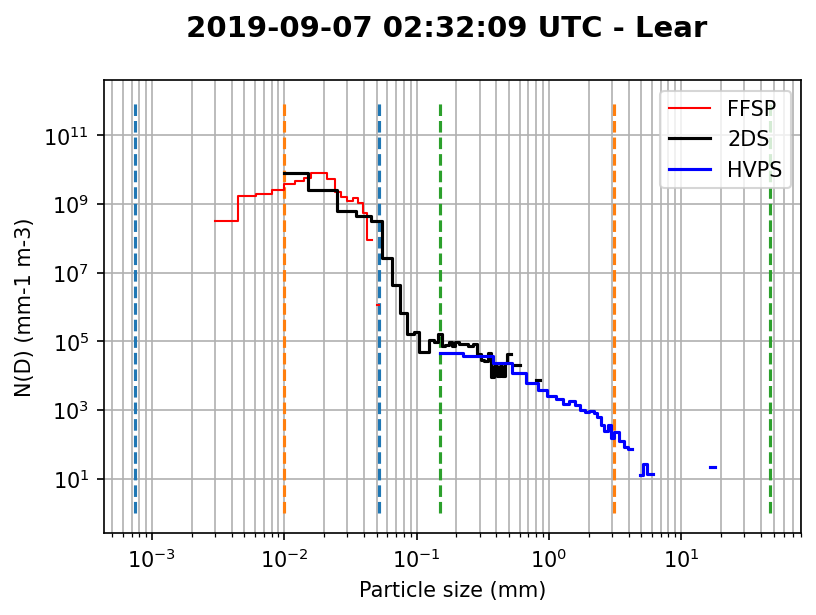

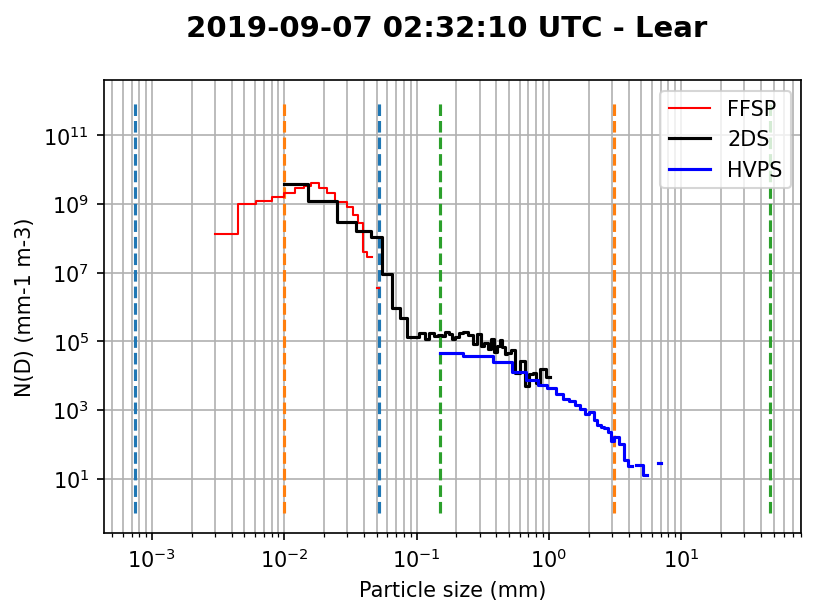

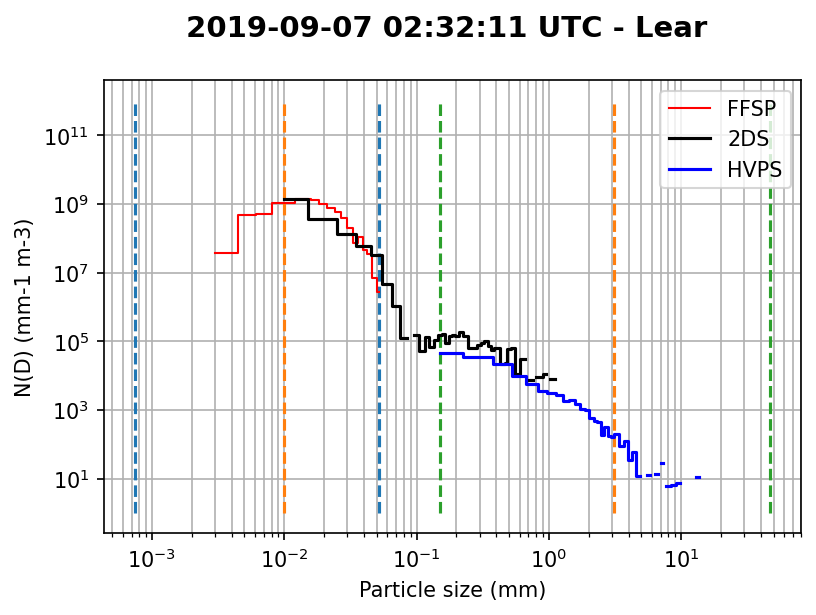

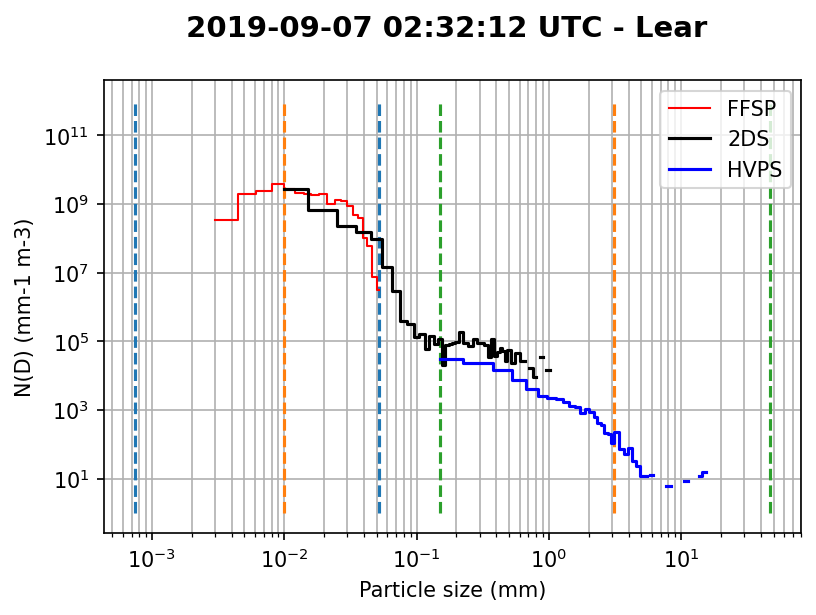

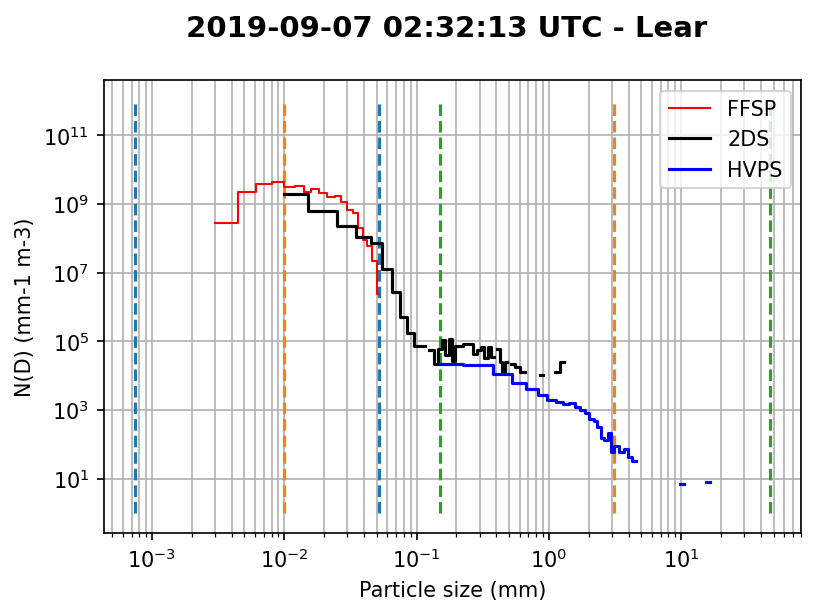

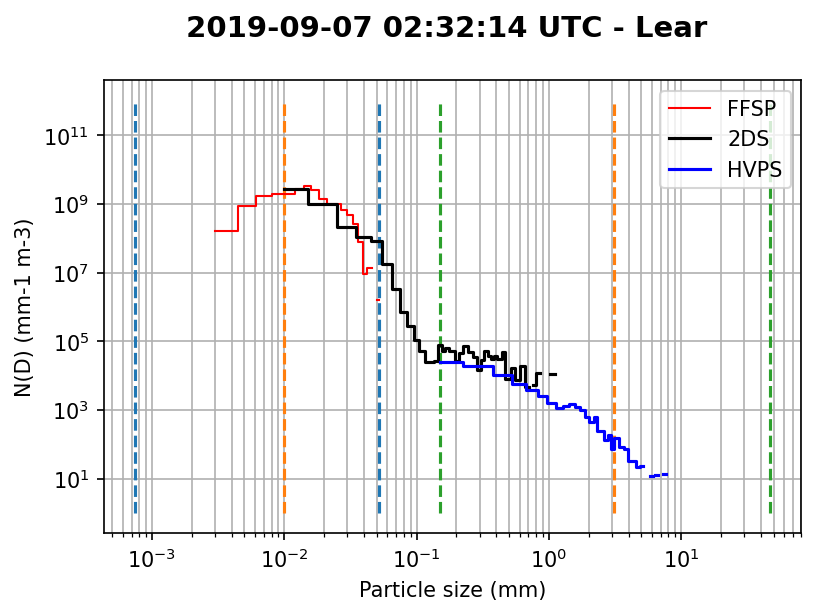

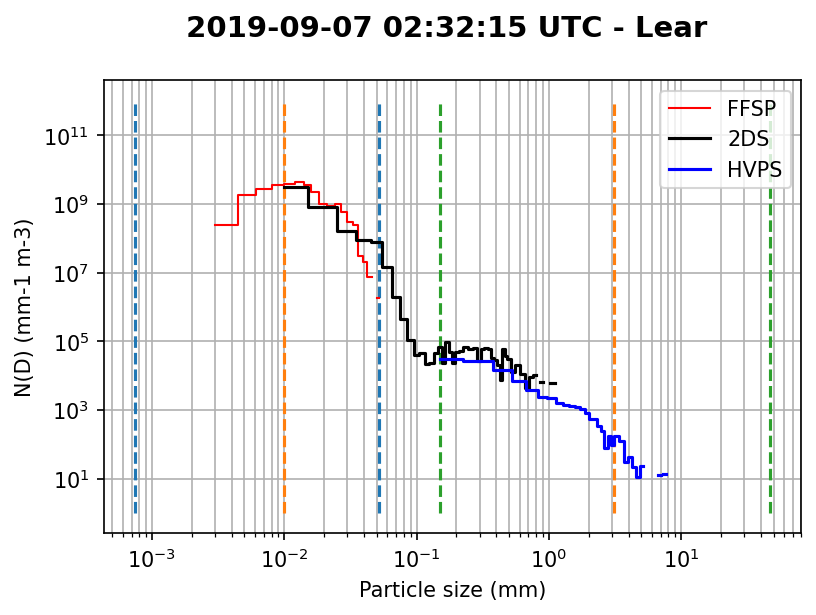

In [32]:
for i in xr_2ds.sel(time=slice('2019-09-07 02:31:50', '2019-09-07 02:32:15')).time:
    fig, ax1 = plt.subplots(dpi=150)
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    ax1.set_ylabel('N(D) (mm-1 m-3)')

    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

No handles with labels found to put in legend.


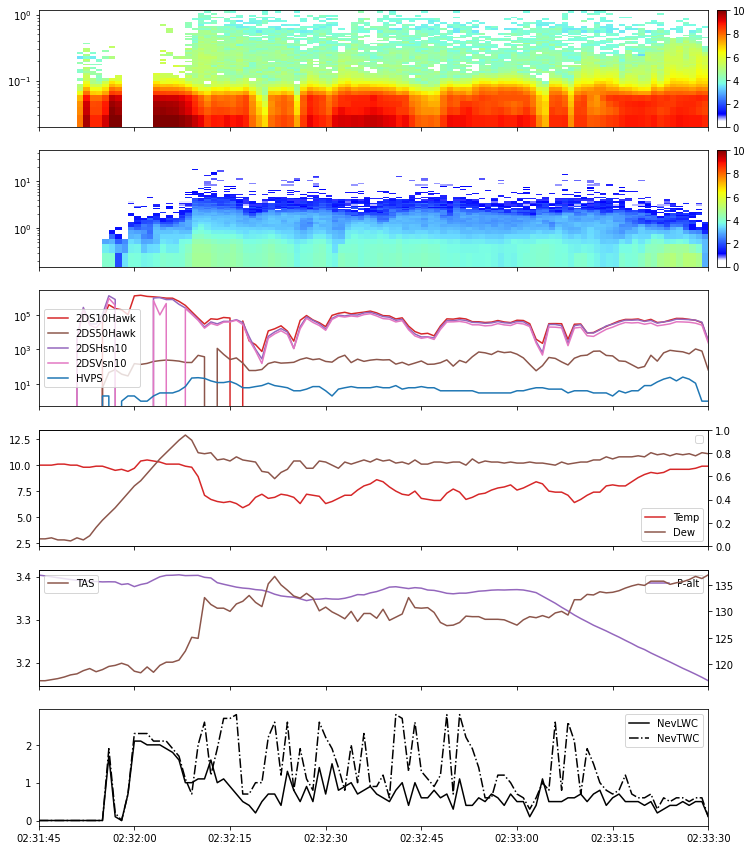

In [11]:
fig, (ax, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1, figsize=(12, 15), sharex=True)

cbar = ax.pcolormesh(xr_2ds.time.sel(time=slice(start, end)), 
                      xr_2ds.diameter.sel(diameter=slice(20, 1200)).values / 1e3, 
                      np.log10(xr_2ds.psd.sel(time=slice(start, end)).sel(diameter=slice(20, 1200)).T.values * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)



cbar1 = ax1.pcolormesh(xr_hvps.time.sel(time=slice(start, end)), 
                      xr_hvps.diameter.values / 1e3, 
                      np.log10(xr_hvps.psd.sel(time=slice(start, end)).T.values *1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)


ax2.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end))['2DS10Hawk'],
         c='C3', label='2DS10Hawk')
ax2.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end))['2DS50Hawk'],
         c='C5', label='2DS50Hawk')

ax2.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end))['2DSHsn10'], 
         c='C4', label='2DSHsn10')

ax2.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end))['2DSVsn10'], 
         c='C6', label='2DSVsn10')

ax2.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end))['HVPS'], 
         c='C10', label='HVPS')

ax3.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).Temp, c='C3', label='Temp')
ax3.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).Dew, c='C5', label='Dew')
ax33 = ax3.twinx()
ax5.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).NevLWC, c='k', label='NevLWC')
ax5.plot(xr_add.sel(time=slice(start, end)).time,
         xr_add.sel(time=slice(start, end)).NevTWC, c='k', ls='-.', label='NevTWC')

ax4.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).Palt * 0.3048 / 1e3, 
         c='C4', label='P-alt')
ax44 = ax4.twinx()
ax44.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).TAS, c='C5', label='TAS')

# ax5.plot(xr_add.sel(time=slice(start, end)).time, xr_add.sel(time=slice(start, end)).Hdg, 
#          c='C4', label='P-heading')

ax1.set_yscale('log')
ax.set_yscale('log')
add_colorbar_outside(cbar, ax)
add_colorbar_outside(cbar1, ax1)
ax2.set_yscale('log')
# ax.plot(xr_hvps.sel(time=slice(start, end)).time, comp_lwc(xr_hvps.sel(time=slice(start, end))).sum("diameter"), 
#         label='HVPS', c='C3', lw=1)
ax2.legend()
ax3.legend()
ax33.legend()
ax44.legend()
ax4.legend()
ax5.legend()
plt.show()

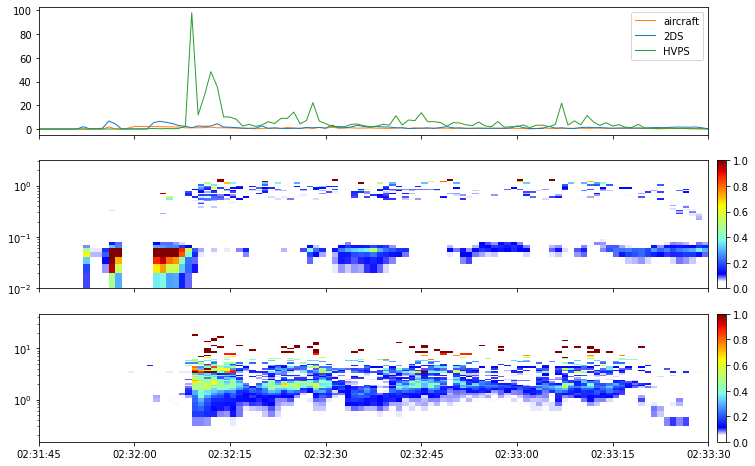

In [12]:
fig, (ax,ax1, ax2) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax.plot(xr_comb_350.sel(time=slice(start, end)).time, xr_comb_350.lwc_plane.sel(time=slice(start, end)),
        label='aircraft', c='C1', lw=1)

ax.plot(xr_2ds.sel(time=slice(start, end)).time, comp_lwc_raw(xr_2ds.sel(time=slice(start, end))).sum("diameter"), 
        label='2DS', c='C0', lw=1)

ax.plot(xr_hvps.sel(time=slice(start, end)).time, comp_lwc_raw(xr_hvps.sel(time=slice(start, end))).sum("diameter"), 
        label='HVPS', c='C2', lw=1)

cbar = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)), 
                      xr_2ds.diameter.values * 1e-3, 
                       comp_lwc_raw(xr_2ds.sel(time=slice(start, end))).T, 
                      vmin=0, vmax=1, cmap=my_cmap)

cbar2 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)), 
                       xr_hvps.diameter.values * 1e-3, 
                       comp_lwc_raw(xr_hvps.sel(time=slice(start, end))).T, 
                       vmin=0, vmax=1, cmap=my_cmap)
ax1.set_yscale('log')
add_colorbar_outside(cbar, ax1)
add_colorbar_outside(cbar2, ax2)
ax2.set_yscale('log')
# ax.plot(xr_hvps.sel(time=slice(start, end)).time, comp_lwc(xr_hvps.sel(time=slice(start, end))).sum("diameter"), 
#         label='HVPS', c='C3', lw=1)
ax.legend()

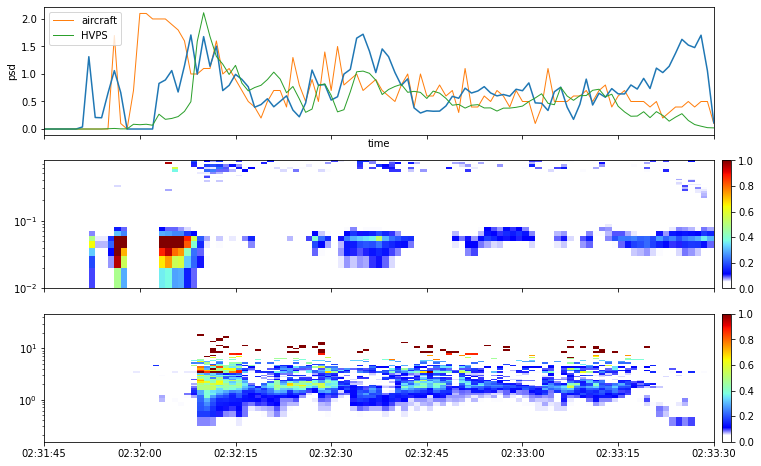

In [13]:
fig, (ax,ax1, ax2) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax.plot(xr_comb_350.sel(time=slice(start, end)).time, xr_comb_350.lwc_plane.sel(time=slice(start, end)),
        label='aircraft', c='C1', lw=1)

lwc = comp_lwc_raw(xr_2ds.sel(time=slice(start, end)).sel(diameter=slice(10, 800)))
lwc.where(lwc < 0.5, np.nan).sum('diameter').plot(ax=ax)
# ax.plot(xr_2ds.sel(time=slice(start, end)).time, comp_lwc_raw(xr_2ds.sel(time=slice(start, end)).sel(diameter=slice(10, 800))).sum("diameter"), 
#         label='2DS', c='C0', lw=1)

ax.plot(xr_hvps.sel(time=slice(start, end)).time, comp_lwc_raw(xr_hvps.sel(time=slice(start, end)).sel(diameter=slice(400, 1400))).sum("diameter"), 
        label='HVPS', c='C2', lw=1)

cbar = ax1.pcolormesh(xr_2ds.sel(time=slice(start, end)).time, 
                      xr_2ds.sel(diameter=slice(10, 800)).diameter.values * 1e-3, 
                      lwc.T, 
                      vmin=0, vmax=1, cmap=my_cmap)

cbar2 = ax2.pcolormesh(xr_hvps.sel(time=slice(start, end)).time, 
                       xr_hvps.diameter.values * 1e-3, 
                       comp_lwc_raw(xr_hvps.sel(time=slice(start, end))).T, 
                       vmin=0, vmax=1, cmap=my_cmap)
ax1.set_yscale('log')
add_colorbar_outside(cbar, ax1)
add_colorbar_outside(cbar2, ax2)
ax2.set_yscale('log')
# ax.plot(xr_hvps.sel(time=slice(start, end)).time, comp_lwc(xr_hvps.sel(time=slice(start, end))).sum("diameter"), 
#         label='HVPS', c='C3', lw=1)
ax.legend()

In [14]:
_upper = 800
_lower = 400

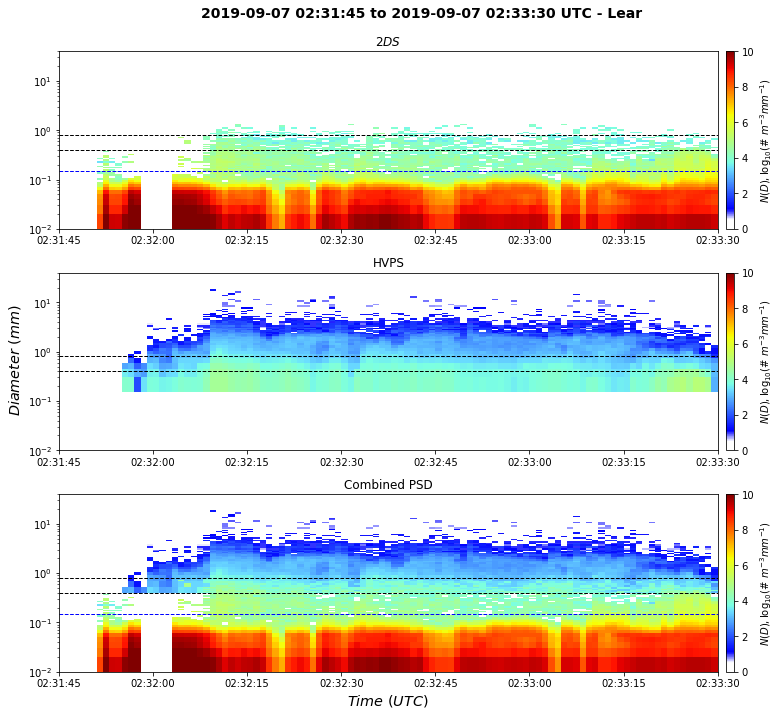

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

cbar = ax3.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter.values, 
                      np.log10(xr_400.psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.psd.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.psd.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()

In [ ]:
_upper = 1200
_lower = 800

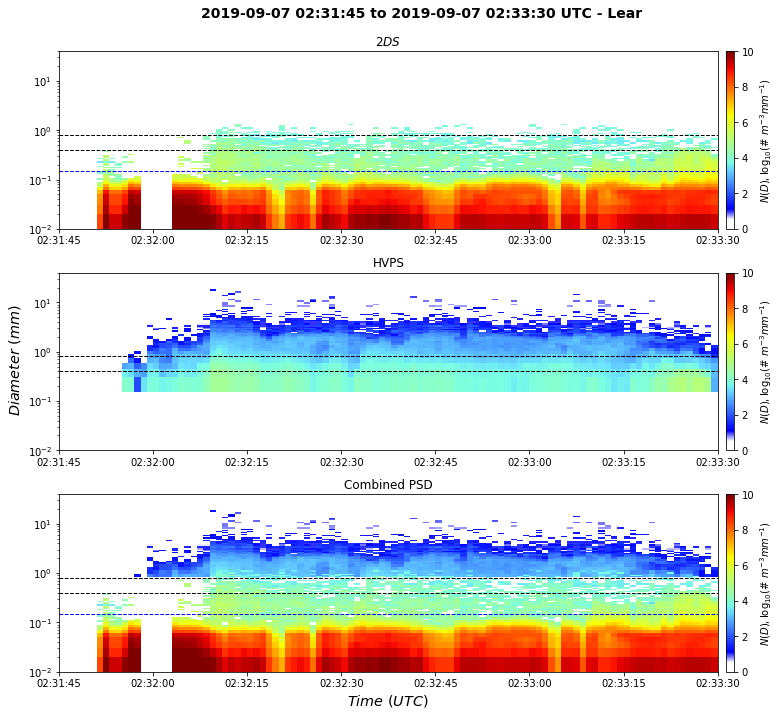

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

cbar = ax3.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.psd.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.psd.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()

NameError: name 'LWC_800' is not defined

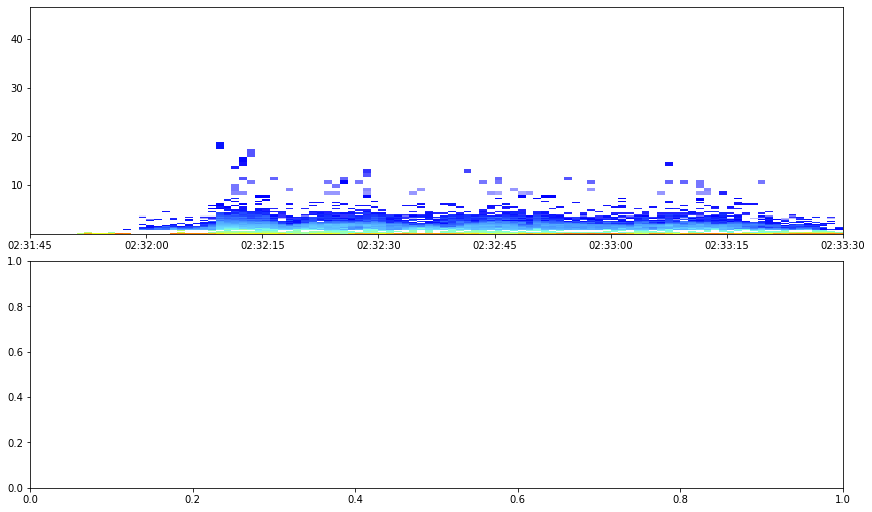

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), constrained_layout=True)

cbar = ax1.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC (g m-3)')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [ ]:
lwc_2ds = (np.pi / (6.  * 1000.)) * (xr_2ds.pds * 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3)

In [ ]:
lwc_hvps = (np.pi / (6.  * 1000.)) * (xr_hvps.pds * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)

cbar = ax.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter.values * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('2DS')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter.values * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_ylim(0, 15)
ax.set_title('HVPS')

# 2ds from 10 to 1000 um


In [43]:
d_2ds = np.tile(xr_2ds.diameter.sel(diameter=slice(10, 825)), 
                [np.shape(xr_2ds.psd.sel(diameter=slice(10, 825)).values)[0], 1])

In [44]:
dd_2ds = np.tile(xr_2ds.dd.sel(diameter=slice(10, 825)),
                 [np.shape(xr_2ds.psd.sel(diameter=slice(10, 825)).values)[0], 1])

AttributeError: 'Dataset' object has no attribute 'dd'

In [ ]:
d_hvps = np.tile(xr_hvps.diameter.sel(diameter=slice(300, 3000)), 
                [np.shape(xr_hvps.pds.sel(diameter=slice(300, 3000)).values)[0], 1])

dd_hvps = np.tile(xr_hvps.dd.sel(diameter=slice(300, 3000)),
                 [np.shape(xr_hvps.pds.sel(diameter=slice(300, 3000)).values)[0], 1])

In [ ]:
lwc_2ds = (np.pi / (6.  * 1000.)) * np.sum((xr_2ds.pds.sel(diameter=slice(10, 825))* 1e6) * (d_2ds * 1e-3) 
                                           ** 3 * (dd_2ds * 1e-3), axis=1)

In [ ]:
d_hvps.shape

In [ ]:
lwc_hvps = (np.pi / (6.  * 1000.)) * np.sum((xr_hvps.pds.sel(diameter=slice(300, 3000)) * 1e6) * (d_hvps * 1e-3) 
                                            ** 3 * (dd_hvps * 1e-3), axis=1)

In [ ]:
LWC_400 = lwc_400.sel(time=slice(start, end))
LWC_800 = lwc_800.sel(time=slice(start, end))
LWC_plane = xr_400.lwc_plane.sel(time=slice(start,end))
LWC_2ds = lwc_2ds.sel(time=slice(start, end))
LWC_hvps = lwc_hvps.sel(time=slice(start, end))

In [ ]:
_lower = 400
_upper = 800

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

cbar = ax1.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter.values, 
                      np.log10(xr_400.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

cbar = ax3.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=50, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [ ]:
lwc_2ds = (np.pi / (6.  * 1000.)) * (xr_2ds.pds.sel(diameter=slice(10, 825))* 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3)

In [ ]:
lwc_hvps = (np.pi / (6.  * 1000.)) * (xr_hvps.pds.sel(diameter=slice(300, 3000)) * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter.values * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('2DS')
ax.set_ylim(1e-2, 2)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter.values * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_ylim(0, 4)

In [ ]:
_upper = 1200
_lower = 800

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), constrained_layout=True)

cbar = ax1.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

# ax2.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC (g m-3)')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

cbar = ax3.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=50, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [ ]:
for i in xr_2ds.sel(time=slice('2019-09-07 00:02:00', '2019-09-07 00:03:00')):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    y = xr_400.merge_psd.sel(time=i)
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_400.diameter * 1e-3, y=y, where='post', c='k', lw=2, label= 'Combined PSD')
    
    y = xr_2ds.pds.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax.step(x=xr_2ds.diameter* 1e-3, y=y, where='post', label='2DS', c='k')

    y = xr_hvps.pds.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax.step(x=xr_hvps.diameter* 1e-3, y=y, where='post', label='HVPS', c='b')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Particle size (mm)')
    ax.set_ylabel('Concentration (# m-3 mm-1)')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax.legend()
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

# ax1.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax1.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax1.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_title('LWC (g m-3)')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax2.legend()
ax1.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()